In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import matplotlib.colors as colors
import os

## Material parameters and other general definitions

In [2]:
# Conversion factors
Oe = 1000/(4*np.pi)     # conversion Oe->A/m 79.577471/ 1 mT->10 Oe

# magnetic parametes
alpha_YIG = 1.75e-4    # Gilbert damping (-)

Ms_YIG = 140.7e3           # Saturation magnetisation (A/m). 

A_YIG = 4.22e-12           # Exchange stiffness (J/m)

l_ex = (2*A_YIG/(mm.consts.mu0*Ms_YIG**2)) # Exchange length (m)


## Sample and mesh cell creation

In [3]:
# Geometry [m]
l = 60e-6
w = 500e-9
t = 50e-9

# self absorbing boundary condition
band = 1e-6

sourceWidth=600e-9 #cercare bene la misura sul righello
sourcePos=-l/4 #almeno iniettiamo le waves nel bulk, possiamo modificare

# Mesh cell [m]
cx = 10e-9   #50e-9
cy = w  #50e-9
cz = t

cell = (cx, cy, cz)

# Initial magnetization
m0 = (1, 0, 0)   # Initial reduced magnetization

## Set bias magnetic field

In [4]:

# Zeeman field
Hx = 0 * Oe # =55mT as in the paper
Hy = 100 * Oe
Hz = 0
H_DC = (Hx, Hy, Hz)


# Amplitude of RF exiting field
H_RF_val=10 * Oe

# w0 = mm.consts.gamma0*mm.consts.mu0*(Hx/Oe)
# wM = mm.consts.gamma0*mm.consts.mu0*Ms_YIG

# print(np.sqrt(w0*wM+w0**2))
# print(wM)
# print(w0)

## Energy and boundary conditions definition

In [5]:
# demagnetizing energy
dem = mm.Demag()
# exchange energy
ex = mm.Exchange(A=A_YIG)
# zeeman energy
zem = mm.Zeeman(H=H_DC, name='bias')

mn = oc.MinDriver()           # minimization driver
td = oc.TimeDriver()          # time driver


## Time simulation parameter definition

In [6]:
T = 100e-9 #100e-9
f_MAX = 10e9
f_Nyquist = 2*f_MAX
n_Nyquist = T*f_Nyquist
n_oversampling = 50
sampling = int(n_Nyquist+n_oversampling)
t_0 = T/sampling

## System definition

In [7]:
sysName=f"P2_{int(T*1e9)}ns_{int(f_MAX*1e-9)}GHz_{Hy/Oe}Oe"
print(sysName)

P2_100ns_10GHz_1000Oe_pureDE


In [8]:

system = mm.System(name=sysName)
region = df.Region(p1=(-l/2, -w/2, 0), p2=(l/2, w/2, t))
mesh = df.Mesh(region=region, cell=cell)

def alpha_abs(point):
    x, y, z = point
    if (-l/2 < x < -l/2+band):
        return (((x+l/2-band)**2)/(band)**2+alpha_YIG)

    if (l/2-band < x < l/2):
        return (((x-l/2+band)**2)/(band)**2+alpha_YIG)

    else:
        return (alpha_YIG)


alpha = df.Field(mesh, nvdim=1, value=alpha_abs)


## System initialization

In [10]:
# macro to return correct saturation magnetisation inside or outside the sample
def Ms_value(pos):
    # from 0, only inside the sample
    x, y, z = pos

    if (-l/2 < x < l/2 and -w/2 < y < w/2 and 0 < z < t):                                        # rect
        return Ms_YIG

    else:                                                                    # empty space
        return 0


system.m = df.Field(mesh, nvdim=3, value=m0, norm=Ms_value)

## Check system current state

In [ ]:
def plotM(system,axis):
    
    if axis=="x":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_x$')
        """
            system.m accesses the megnetization
            m.x accesses the x component
            x.sel("z") means "sliced at a fixed value of z", by defaut the middle of the system
            from mpl.scalar on it's just about putting the red/blue color code on the right
            """
        system.m.x.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
        """
            this basically just shows the vaues of the vector field m, as colored dots/arrows. 
            Uses the matplotlib.quiver method
            for low fields you only see yellow dots since the equilibrium magnetization is parallel to z
            """
    elif axis=="y":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_y$')
        system.m.y.sel('z').mpl.scalar(ax=ax,vmin=-Ms_YIG,vmax=Ms_YIG,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)
    elif axis=="z":
        fig,ax =plt.subplots(figsize=(25,10))
        plt.title('$\hat m_z$')
        system.m.z.sel('z').mpl.scalar(ax=ax,vmin=-1000,vmax=1000,cmap='seismic')
        system.m.sel('z').resample((20,10)).mpl.vector(ax=ax,headwidth=3,scale=2e7)

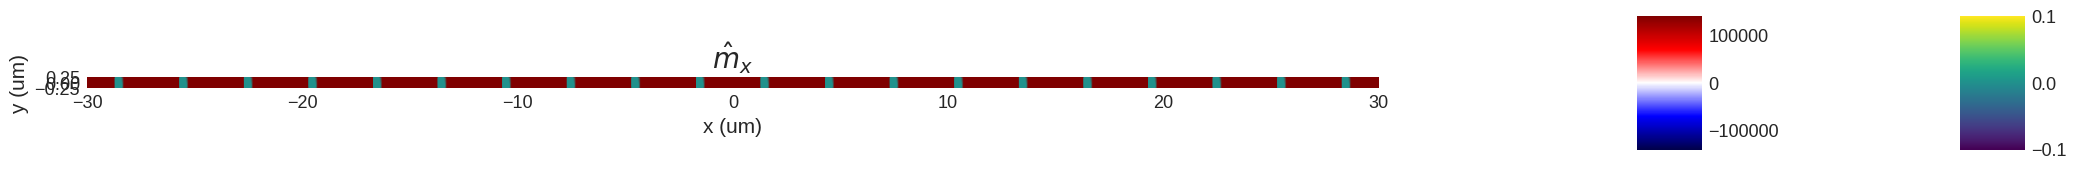

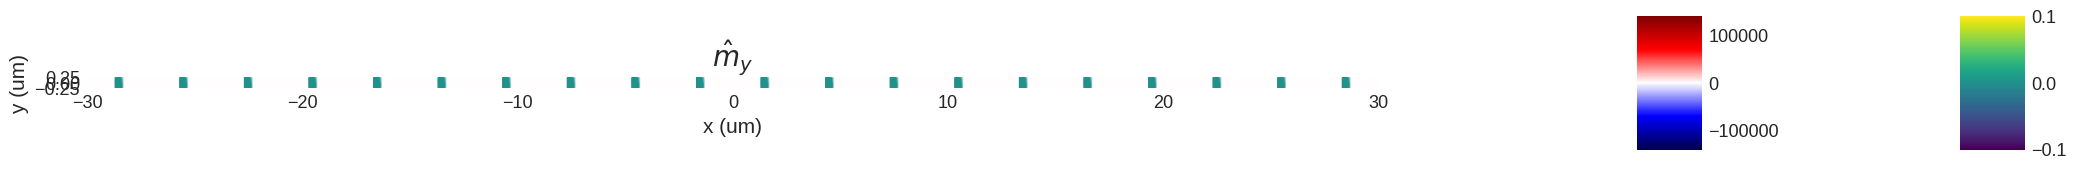

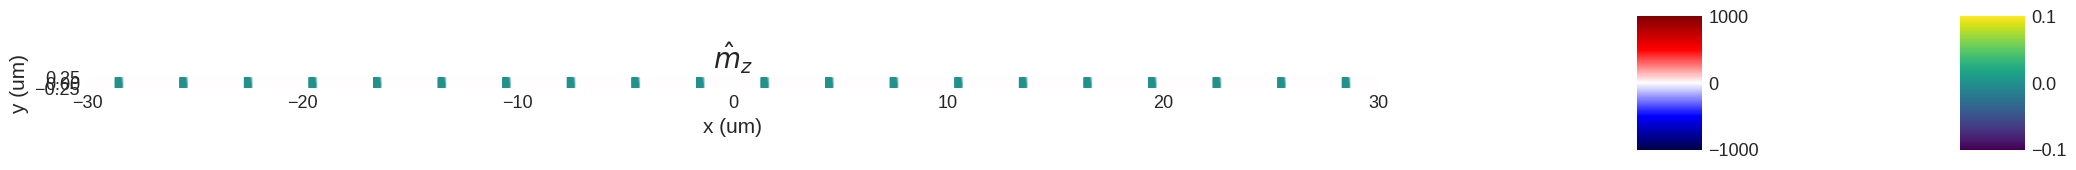

In [ ]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")
      

## Drive to equilibrium state

In [12]:
# get system to equilibrium
system.energy = dem + ex + zem
mn.drive(system)

damping = mm.Damping(alpha=alpha_YIG)
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + damping

Running OOMMF (ExeOOMMFRunner)[2024/01/29 15:33]... (0.9 s)


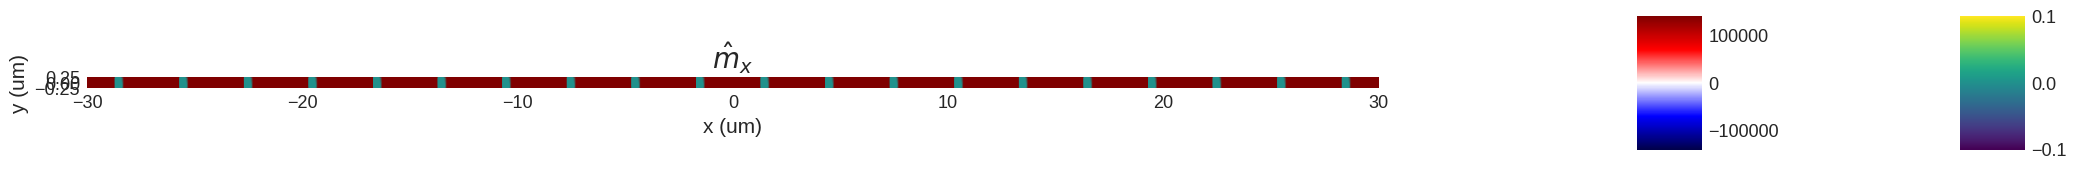

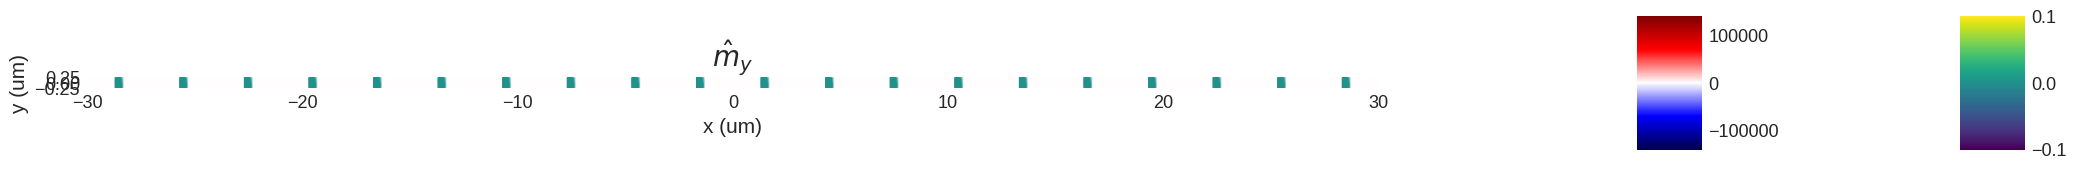

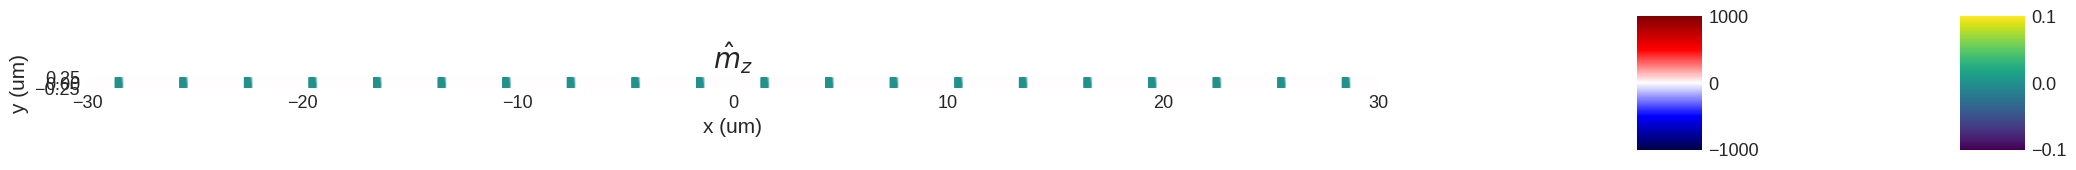

In [ ]:
plotM(system,"x")
plotM(system,"y")
plotM(system,"z")

## RF injection

In [114]:
def Hspace_RF(point):
    x, y, z = point
    if (sourcePos-sourceWidth/2< x < sourcePos+sourceWidth/2 and -w/2 < y < w/2 and 0 < z < t):
        return (0, 0, H_RF_val)
    else:
        return (0,0,0)



H_RF = df.Field(mesh, nvdim=3, value=Hspace_RF)
zemRF = mm.Zeeman(H=H_RF, func='sinc', f=f_MAX, t0=T/sampling, name='RF')
try:
    system.energy += zemRF
finally:
    td.drive(system, t=T, n=sampling, n_threads=19, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/2050 files written [00:00]

Running OOMMF (ExeOOMMFRunner)[2024/01/29 04:09] took 498.4 s


ValueError: There is already a term of type <class 'micromagneticmodel.energy.zeeman.Zeeman'> with  name 'RF' in <class 'micromagneticmodel.energy.energy.Energy'>. Please provide a different name for Zeeman(H=Field(Mesh(Region(pmin=[-3e-05, -2.5e-07, 0.0], pmax=[3e-05, 2.5e-07, 5e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[6000, 1, 1]), nvdim=3, vdims: (x, y, z)), f=10000000000.0, t0=4.878048780487805e-11, func='sinc').

In [8]:
data = md.Data(sysName)[-1]

array = data.to_xarray()
#data.info


In [9]:
data_np = np.array(array)

mx = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 0]
my = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 1]
mz = data_np[:, round((band)/cx):round((l-band)/cx), 0, 0, 2]

In [70]:
# questo non ho ben capito a cosa serva, nel senso che Ax è letteralmente uguale a mx, almeno nei miei test
Ax = np.reshape(mx, (-1, round(l/cx-2*band/cx)))
Ax = np.fliplr(Ax)
# 2d perchè ci serve lungo il primo asse (tempo) e lungo il secondo (spazio)
m_fft_x = np.fft.fft2(Ax)
m_fft_x = np.fft.fftshift(m_fft_x)  # questo centra le frequenze

Ay = np.reshape(my, (-1, round(l/cx-2*band/cx)))
Ay = np.fliplr(Ay)
m_fft_y = np.fft.fft2(Ay)
m_fft_y = np.fft.fftshift(m_fft_y)

Az = np.reshape(mz, (-1, round(l/cx-2*band/cx)))
Az = np.fliplr(Az)
m_fft_z = np.fft.fft2(Az)
m_fft_z = np.fft.fftshift(m_fft_z)

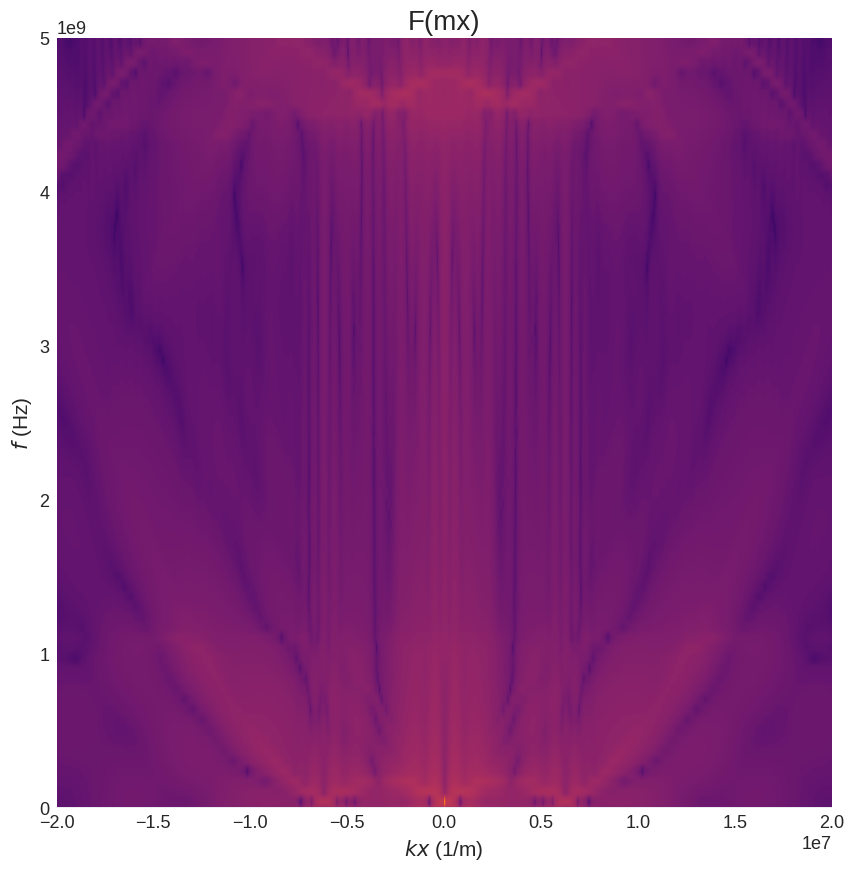

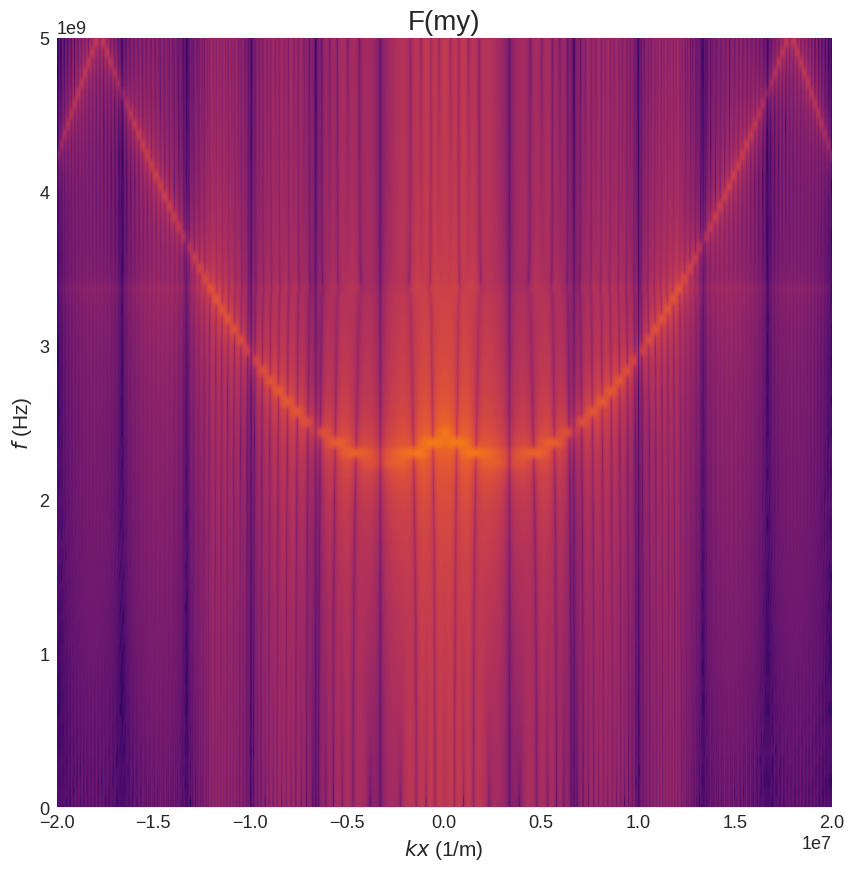

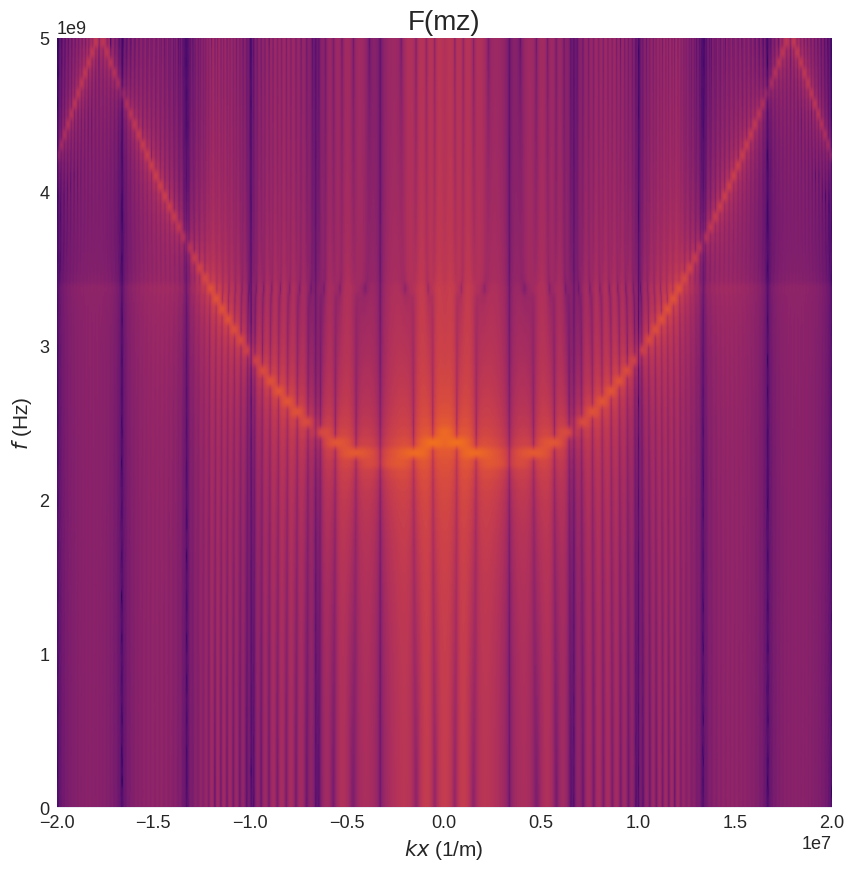

In [ ]:
import matplotlib.colors as colors
import os
directory="images"
parentDir=f"{sysName}"
path=os.path.join(parentDir,directory)
if not os.path.isdir(path):
    os.mkdir(path)

# Show the intensity plot of the 2D FFT
def plotDispersion(m_fft,xbounds,ybounds,dim):
    #mx
    plt.figure(figsize=(10, 10))

    extent = [-1/cx, 1/cx, -f_MAX, f_MAX]  # extent of k values and frequencies
    plt.imshow(np.log(np.abs(m_fft)**2), extent=extent,
           aspect='auto', origin='lower', norm=colors.CenteredNorm(vcenter=22), cmap="inferno")
    plt.ylabel("$f$ (Hz)")
    plt.xlabel("$kx$ (1/m)")
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    if dim=="x":
        plt.title('F(mx)')
        plt.savefig(f'{sysName}/images/F(mx).png', bbox_inches='tight')
    elif dim=="y":
        plt.title('F(my)')
        plt.savefig(f'{sysName}/images/F(my).png', bbox_inches='tight')
    if dim=="z":
        plt.title('F(mz)')
        plt.savefig(f'{sysName}/images/F(mz).png', bbox_inches='tight')

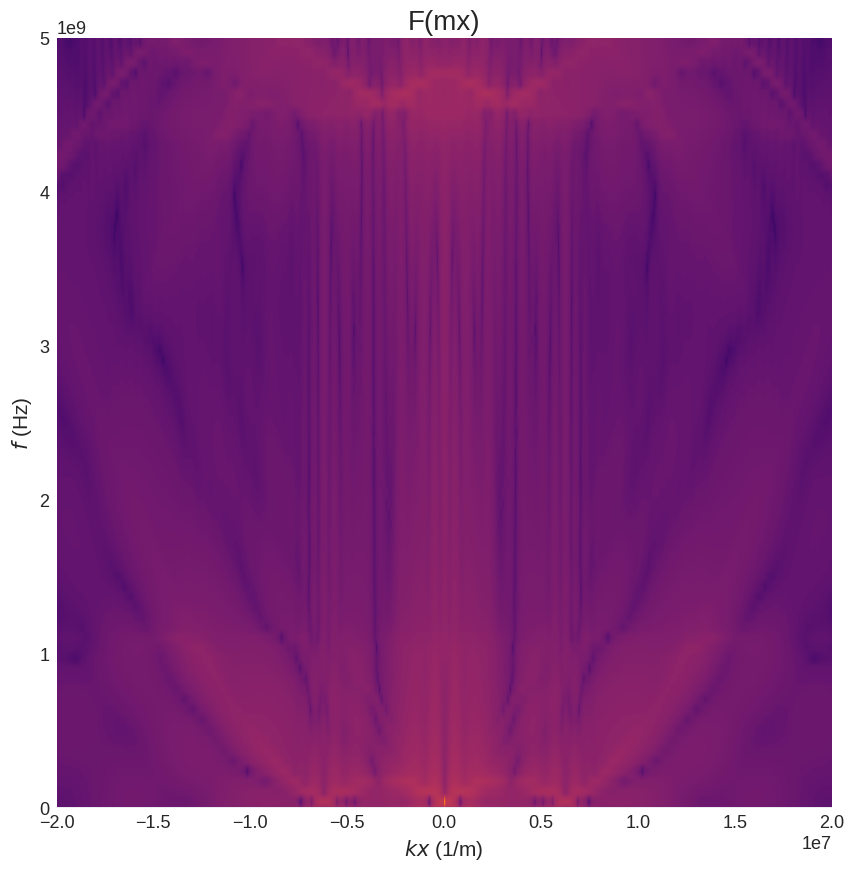

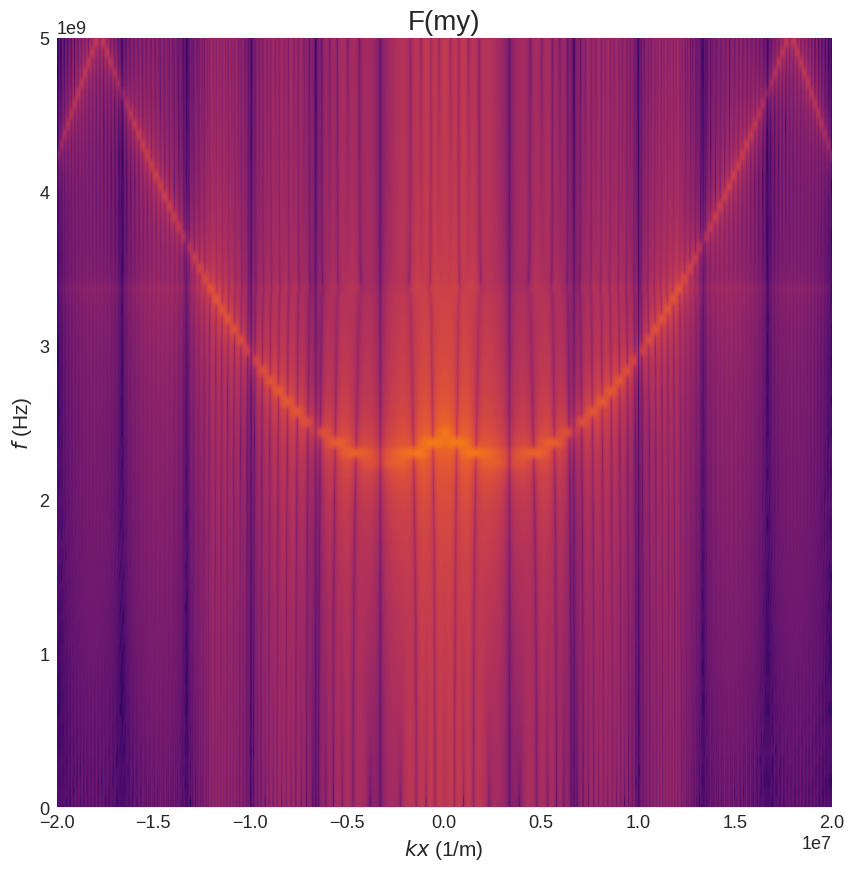

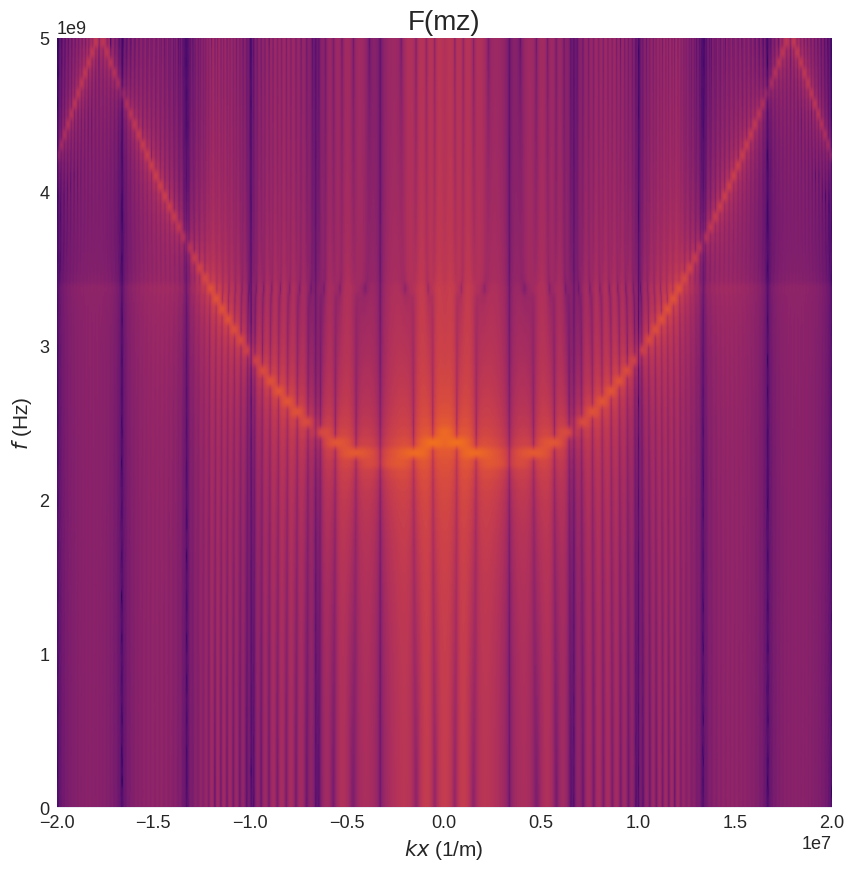

In [ ]:
xbounds=(-1/(5*cx),1/(5*cx))
ybounds=(0,f_MAX)
plotDispersion(m_fft_x,xbounds,ybounds,'x')
plotDispersion(m_fft_y,xbounds,ybounds,'y')
plotDispersion(m_fft_z,xbounds,ybounds,'z')

### Save simulation parameters in params.txt file

In [119]:
#import os
#cwd = os.getcwd()

with open(f"{sysName}/params.txt",'w') as f:
    if cy==w and cz==t:
        f.write(f"cell=({cx},w,t)\n")
    elif cy==w:
        f.write(f"cell=({cx},w,{cz})\n")
    elif cz==t:
        f.write(f"cell=({cx},{cy},t)\n")
    else:
        f.write(f"cell=({cx},{cy},{cz})")
    f.write("\n")
    f.write("Bias field:\n")
    f.write(f"Hx={Hx/Oe}Oe\n")
    f.write(f"Hy={Hy/Oe}Oe\n")
    f.write(f"Hz={Hz/Oe}Oe\n")
    f.write("\n")
    f.write("Exitation field:\n")
    f.write(f"Amplitude={H_RF_val}\n")
    f.write(f"f_MAX={f_MAX}\n")